In [2]:
!pip install aeon > /dev/null

## Carregando o repositório do GitHub com os dados

In [3]:
!git clone https://github.com/andryll/Cortisol-Estimator-with-DL

Cloning into 'Cortisol-Estimator-with-DL'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 101 (delta 4), reused 9 (delta 2), pack-reused 88 (from 1)
Receiving objects: 100% (101/101), 54.44 MiB | 14.73 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [4]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU(s) detected: {gpus}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("No GPU detected. Please ensure your Colab runtime is set to 'GPU' (Runtime -> Change runtime type -> T4 GPU).")

No GPU detected. Please ensure your Colab runtime is set to 'GPU' (Runtime -> Change runtime type -> T4 GPU).


## Carregando e Preparando os Dados


1.   Os dados de treino, teste e validação são carregados e concatenados, de modo a desfazer a divisão feita anteriormente.

2.   Em seguida, os dados de teste são normalizados com o StandardScaler




In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler

data_X = np.load("../data/X_train.npy")
data_X = np.concatenate((data_X, np.load("../data/X_val.npy")), axis=0)
data_X = np.concatenate((data_X, np.load("../data/X_test.npy")), axis=0)

data_y = np.load("../data/y_train.npy")
data_y = np.concatenate((data_y, np.load("../data/y_val.npy")), axis=0)
data_y = np.concatenate((data_y, np.load("../data/y_test.npy")), axis=0)

scaler = StandardScaler()
n_samples, n_timesteps, n_features = data_X.shape
data_X_reshaped = data_X.reshape(-1, n_features)

data_X = scaler.fit_transform(data_X_reshaped)
data_X = data_X.reshape(n_samples, n_timesteps, n_features)

# data_X = data_X[:,:,[1,3]]

print("data_X shape:", data_X.shape)
print("data_y shape:", data_y.shape)

data_X shape: (148, 587, 4)
data_y shape: (148,)


In [4]:
y_mean = data_y.mean()
y_mean

np.float64(16.448026206499524)

## Realizando a Regressão com o FCN

In [2]:
from aeon.regression.deep_learning import FCNRegressor, InceptionTimeRegressor
from aeon.regression.convolution_based import RocketRegressor
from sklearn.model_selection import KFold, LeaveOneOut  
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping # Importar EarlyStopping

# Realizando o KFold split com 10 folds
# n_splits = 10
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
kf = LeaveOneOut()  # Única mudança necessária
n_splits = kf.get_n_splits(data_X)  # Isso retornará o número de amostras

mses_fcn = [] # Lista para armazenar o MSE de cada Fold
r2s_fcn = [] # Lista para armazenar o R2 de cada Fold

mses_it = [] # Lista para armazenar o MSE de cada Fold
r2s_it = [] # Lista para armazenar o R2 de cada Fold

mses_rock = [] # Lista para armazenar o MSE de cada Fold
r2s_rock = [] # Lista para armazenar o R2 de cada Fold

print(f"Realizando o {n_splits}-fold cross-validation...")

# Definir o callback de Early Stopping
early_stopping_callback = EarlyStopping(
    monitor='loss',  # Monitorar a perda de validação
    patience=20,         # Número de épocas sem melhora após o qual o treinamento será interrompido
    restore_best_weights=True # Restaura os pesos do modelo da melhor época
)

# Loop iterando cada uma das pastas
for fold, (train_index, test_index) in enumerate(kf.split(data_X)): # Enumerando as pastas
    print(f"\nFold {fold+1}/{n_splits}")

    # Dividindo os dados de acordo com a pasta atual
    X_train_fold, X_test_fold = data_X[train_index], data_X[test_index]
    y_train_fold, y_test_fold = data_y[train_index], data_y[test_index]

    # Inicializando o RocketRegressor
    rock = RocketRegressor(n_kernels=10000)

    # Inicializando o InceptionTimeRegressor com 100 épocas
    it = InceptionTimeRegressor(n_epochs=100,
                                 batch_size=8,
                                 verbose = False,
                                 callbacks=[early_stopping_callback],
                                metrics = ['mse','r2_score'])

    # Inicializando o FCNRegressor com 100 épocas
    fcn = FCNRegressor(n_epochs=100,
                       batch_size=8,
                       verbose = False,
                       callbacks=[early_stopping_callback],
                       metrics = ['mse','r2_score'])

    # Treinando o Regressor, passando o callback e definindo uma parte para validação
    rock.fit(X_train_fold, y_train_fold)
    it.fit(X_train_fold, y_train_fold)
    fcn.fit(X_train_fold, y_train_fold)

    # Realizando as predições
    y_pred_fold_rock = rock.predict(X_test_fold)
    y_pred_fold_it = it.predict(X_test_fold)
    y_pred_fold_fcn = fcn.predict(X_test_fold)

    # Calculando o MSE para a pasta atual
    mse_fold_rock = mean_squared_error(y_test_fold, y_pred_fold_rock)
    mses_rock.append(mse_fold_rock)

    mse_fold_it = mean_squared_error(y_test_fold, y_pred_fold_it)
    mses_it.append(mse_fold_it)

    mse_fold_fcn = mean_squared_error(y_test_fold, y_pred_fold_fcn)
    mses_fcn.append(mse_fold_fcn)

    # Calculando o R2 score para a pasta atual
    r2_fold_rock = r2_score(y_test_fold, y_pred_fold_rock)
    r2s_rock.append(r2_fold_rock)

    r2_fold_it = r2_score(y_test_fold, y_pred_fold_it)
    r2s_it.append(r2_fold_it)

    r2_fold_fcn = r2_score(y_test_fold, y_pred_fold_fcn)
    r2s_fcn.append(r2_fold_fcn)

    print(f"MSE para a pasta {fold+1} (Rocket): {mse_fold_rock:.4f}")
    print(f"R2 Score para a pasta {fold+1} (Rocket): {r2_fold_rock:.4f}")

    print(f"MSE para a pasta {fold+1} (InceptionTime): {mse_fold_it:.4f}")
    print(f"R2 Score para a pasta {fold+1} (IncpetionTime): {r2_fold_it:.4f}")

    print(f"MSE para a pasta {fold+1} (FCN): {mse_fold_fcn:.4f}")
    print(f"R2 Score para a pasta {fold+1} (FCN): {r2_fold_fcn:.4f}")

# Calculando a média dos MSE e R2
average_mse_rock = np.mean(mses_rock)
average_r2_rock = np.mean(r2s_rock)

average_mse_it = np.mean(mses_it)
average_r2_it = np.mean(r2s_it)

average_mse_fcn = np.mean(mses_fcn)
average_r2_fcn = np.mean(r2s_fcn)

print(f"\nAverage MSE across {n_splits} folds (Rocket): {average_mse_rock:.4f}")
print(f"Average R2 Score across {n_splits} folds (Rocket): {average_r2_rock:.4f}")

print(f"\nAverage MSE across {n_splits} folds (InceptionTime): {average_mse_it:.4f}")
print(f"Average R2 Score across {n_splits} folds (InceptionTime): {average_r2_it:.4f}")

print(f"\nAverage MSE across {n_splits} folds (FCN): {average_mse_fcn:.4f}")
print(f"Average R2 Score across {n_splits} folds (FCN): {average_r2_fcn:.4f}")


Realizando o 148-fold cross-validation...

Fold 1/148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
MSE para a pasta 1 (Rocket): 196.3485
R2 Score para a pasta 1 (Rocket): nan
MSE para a pasta 1 (InceptionTime): 44.9957
R2 Score para a pasta 1 (IncpetionTime): nan
MSE para a pasta 1 (FCN): 101.5015
R2 Score para a pasta 1 (FCN): nan

Fold 2/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
MSE para a pasta 2 (Rocket): 129.5471
R2 Score para a pasta 2 (Rocket): nan
MSE para a pasta 2 (InceptionTime): 58.3195
R2 Score para a pasta 2 (IncpetionTime): nan
MSE para a pasta 2 (FCN): 5.7086
R2 Score para a pasta 2 (FCN): nan

Fold 3/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
MSE para a pasta 3 (Rocket): 8.3091
R2 Score para a pasta 3 (Rocket): nan
MSE para a pasta 3 (InceptionTime): 0.1015
R2 Score para a pasta 3 (IncpetionTime): nan
MSE para a pasta 3 (FCN): 29.1935
R2 Score para a pasta 3 (FCN): nan

Fold 4/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
MSE para a pasta 4 (Rocket): 1.6132
R2 Score para a pasta 4 (Rocket): nan
MSE para a pasta 4 (InceptionTime): 33.9044
R2 Score para a pasta 4 (IncpetionTime): nan
MSE para a pasta 4 (FCN): 19.8960
R2 Score para a pasta 4 (FCN): nan

Fold 5/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
MSE para a pasta 5 (Rocket): 157.0739
R2 Score para a pasta 5 (Rocket): nan
MSE para a pasta 5 (InceptionTime): 82.7409
R2 Score para a pasta 5 (IncpetionTime): nan
MSE para a pasta 5 (FCN): 399.7895
R2 Score para a pasta 5 (FCN): nan

Fold 6/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
MSE para a pasta 6 (Rocket): 21.5595
R2 Score para a pasta 6 (Rocket): nan
MSE para a pasta 6 (InceptionTime): 28.6046
R2 Score para a pasta 6 (IncpetionTime): nan
MSE para a pasta 6 (FCN): 3.4531
R2 Score para a pasta 6 (FCN): nan

Fold 7/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
MSE para a pasta 7 (Rocket): 46.5488
R2 Score para a pasta 7 (Rocket): nan
MSE para a pasta 7 (InceptionTime): 0.3338
R2 Score para a pasta 7 (IncpetionTime): nan
MSE para a pasta 7 (FCN): 13.7732
R2 Score para a pasta 7 (FCN): nan

Fold 8/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
MSE para a pasta 8 (Rocket): 12.1553
R2 Score para a pasta 8 (Rocket): nan
MSE para a pasta 8 (InceptionTime): 0.1467
R2 Score para a pasta 8 (IncpetionTime): nan
MSE para a pasta 8 (FCN): 0.6878
R2 Score para a pasta 8 (FCN): nan

Fold 9/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
MSE para a pasta 9 (Rocket): 50.6237
R2 Score para a pasta 9 (Rocket): nan
MSE para a pasta 9 (InceptionTime): 2.3308
R2 Score para a pasta 9 (IncpetionTime): nan
MSE para a pasta 9 (FCN): 0.1717
R2 Score para a pasta 9 (FCN): nan

Fold 10/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
MSE para a pasta 10 (Rocket): 24.8860
R2 Score para a pasta 10 (Rocket): nan
MSE para a pasta 10 (InceptionTime): 12.9395
R2 Score para a pasta 10 (IncpetionTime): nan
MSE para a pasta 10 (FCN): 109.3085
R2 Score para a pasta 10 (FCN): nan

Fold 11/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
MSE para a pasta 11 (Rocket): 3.6622
R2 Score para a pasta 11 (Rocket): nan
MSE para a pasta 11 (InceptionTime): 14.0626
R2 Score para a pasta 11 (IncpetionTime): nan
MSE para a pasta 11 (FCN): 11.3134
R2 Score para a pasta 11 (FCN): nan

Fold 12/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
MSE para a pasta 12 (Rocket): 1.9411
R2 Score para a pasta 12 (Rocket): nan
MSE para a pasta 12 (InceptionTime): 18.2256
R2 Score para a pasta 12 (IncpetionTime): nan
MSE para a pasta 12 (FCN): 29.4135
R2 Score para a pasta 12 (FCN): nan

Fold 13/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
MSE para a pasta 13 (Rocket): 55.8770
R2 Score para a pasta 13 (Rocket): nan
MSE para a pasta 13 (InceptionTime): 78.3226
R2 Score para a pasta 13 (IncpetionTime): nan
MSE para a pasta 13 (FCN): 347.2928
R2 Score para a pasta 13 (FCN): nan

Fold 14/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
MSE para a pasta 14 (Rocket): 202.8375
R2 Score para a pasta 14 (Rocket): nan
MSE para a pasta 14 (InceptionTime): 303.1695
R2 Score para a pasta 14 (IncpetionTime): nan
MSE para a pasta 14 (FCN): 501.4691
R2 Score para a pasta 14 (FCN): nan

Fold 15/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
MSE para a pasta 15 (Rocket): 5.7807
R2 Score para a pasta 15 (Rocket): nan
MSE para a pasta 15 (InceptionTime): 4.0276
R2 Score para a pasta 15 (IncpetionTime): nan
MSE para a pasta 15 (FCN): 3.2214
R2 Score para a pasta 15 (FCN): nan

Fold 16/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
MSE para a pasta 16 (Rocket): 29.7146
R2 Score para a pasta 16 (Rocket): nan
MSE para a pasta 16 (InceptionTime): 1.4767
R2 Score para a pasta 16 (IncpetionTime): nan
MSE para a pasta 16 (FCN): 30.6800
R2 Score para a pasta 16 (FCN): nan

Fold 17/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
MSE para a pasta 17 (Rocket): 111.8311
R2 Score para a pasta 17 (Rocket): nan
MSE para a pasta 17 (InceptionTime): 176.2189
R2 Score para a pasta 17 (IncpetionTime): nan
MSE para a pasta 17 (FCN): 864.0420
R2 Score para a pasta 17 (FCN): nan

Fold 18/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
MSE para a pasta 18 (Rocket): 138.7194
R2 Score para a pasta 18 (Rocket): nan
MSE para a pasta 18 (InceptionTime): 324.5081
R2 Score para a pasta 18 (IncpetionTime): nan
MSE para a pasta 18 (FCN): 659.9434
R2 Score para a pasta 18 (FCN): nan

Fold 19/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
MSE para a pasta 19 (Rocket): 54.5199
R2 Score para a pasta 19 (Rocket): nan
MSE para a pasta 19 (InceptionTime): 0.0190
R2 Score para a pasta 19 (IncpetionTime): nan
MSE para a pasta 19 (FCN): 2.7533
R2 Score para a pasta 19 (FCN): nan

Fold 20/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
MSE para a pasta 20 (Rocket): 0.2329
R2 Score para a pasta 20 (Rocket): nan
MSE para a pasta 20 (InceptionTime): 2.8329
R2 Score para a pasta 20 (IncpetionTime): nan
MSE para a pasta 20 (FCN): 6.2854
R2 Score para a pasta 20 (FCN): nan

Fold 21/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
MSE para a pasta 21 (Rocket): 119.4904
R2 Score para a pasta 21 (Rocket): nan
MSE para a pasta 21 (InceptionTime): 0.0303
R2 Score para a pasta 21 (IncpetionTime): nan
MSE para a pasta 21 (FCN): 0.3021
R2 Score para a pasta 21 (FCN): nan

Fold 22/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
MSE para a pasta 22 (Rocket): 77.2049
R2 Score para a pasta 22 (Rocket): nan
MSE para a pasta 22 (InceptionTime): 0.1283
R2 Score para a pasta 22 (IncpetionTime): nan
MSE para a pasta 22 (FCN): 0.4315
R2 Score para a pasta 22 (FCN): nan

Fold 23/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
MSE para a pasta 23 (Rocket): 111.9739
R2 Score para a pasta 23 (Rocket): nan
MSE para a pasta 23 (InceptionTime): 0.4927
R2 Score para a pasta 23 (IncpetionTime): nan
MSE para a pasta 23 (FCN): 2.2351
R2 Score para a pasta 23 (FCN): nan

Fold 24/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
MSE para a pasta 24 (Rocket): 3.0952
R2 Score para a pasta 24 (Rocket): nan
MSE para a pasta 24 (InceptionTime): 33.4068
R2 Score para a pasta 24 (IncpetionTime): nan
MSE para a pasta 24 (FCN): 3.8860
R2 Score para a pasta 24 (FCN): nan

Fold 25/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
MSE para a pasta 25 (Rocket): 284.7923
R2 Score para a pasta 25 (Rocket): nan
MSE para a pasta 25 (InceptionTime): 497.6017
R2 Score para a pasta 25 (IncpetionTime): nan
MSE para a pasta 25 (FCN): 309.1901
R2 Score para a pasta 25 (FCN): nan

Fold 26/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
MSE para a pasta 26 (Rocket): 405.6933
R2 Score para a pasta 26 (Rocket): nan
MSE para a pasta 26 (InceptionTime): 360.7218
R2 Score para a pasta 26 (IncpetionTime): nan
MSE para a pasta 26 (FCN): 113.6039
R2 Score para a pasta 26 (FCN): nan

Fold 27/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
MSE para a pasta 27 (Rocket): 190.1796
R2 Score para a pasta 27 (Rocket): nan
MSE para a pasta 27 (InceptionTime): 224.1248
R2 Score para a pasta 27 (IncpetionTime): nan
MSE para a pasta 27 (FCN): 324.6191
R2 Score para a pasta 27 (FCN): nan

Fold 28/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
MSE para a pasta 28 (Rocket): 1.2530
R2 Score para a pasta 28 (Rocket): nan
MSE para a pasta 28 (InceptionTime): 1.5001
R2 Score para a pasta 28 (IncpetionTime): nan
MSE para a pasta 28 (FCN): 33.1289
R2 Score para a pasta 28 (FCN): nan

Fold 29/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
MSE para a pasta 29 (Rocket): 28.4797
R2 Score para a pasta 29 (Rocket): nan
MSE para a pasta 29 (InceptionTime): 25.6289
R2 Score para a pasta 29 (IncpetionTime): nan
MSE para a pasta 29 (FCN): 1.4724
R2 Score para a pasta 29 (FCN): nan

Fold 30/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
MSE para a pasta 30 (Rocket): 206.9744
R2 Score para a pasta 30 (Rocket): nan
MSE para a pasta 30 (InceptionTime): 118.6554
R2 Score para a pasta 30 (IncpetionTime): nan
MSE para a pasta 30 (FCN): 25.6689
R2 Score para a pasta 30 (FCN): nan

Fold 31/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
MSE para a pasta 31 (Rocket): 573.4055
R2 Score para a pasta 31 (Rocket): nan
MSE para a pasta 31 (InceptionTime): 652.3354
R2 Score para a pasta 31 (IncpetionTime): nan
MSE para a pasta 31 (FCN): 411.7663
R2 Score para a pasta 31 (FCN): nan

Fold 32/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
MSE para a pasta 32 (Rocket): 9.3708
R2 Score para a pasta 32 (Rocket): nan
MSE para a pasta 32 (InceptionTime): 1.6185
R2 Score para a pasta 32 (IncpetionTime): nan
MSE para a pasta 32 (FCN): 12.3516
R2 Score para a pasta 32 (FCN): nan

Fold 33/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
MSE para a pasta 33 (Rocket): 0.0374
R2 Score para a pasta 33 (Rocket): nan
MSE para a pasta 33 (InceptionTime): 1.6140
R2 Score para a pasta 33 (IncpetionTime): nan
MSE para a pasta 33 (FCN): 5.3068
R2 Score para a pasta 33 (FCN): nan

Fold 34/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
MSE para a pasta 34 (Rocket): 1.1646
R2 Score para a pasta 34 (Rocket): nan
MSE para a pasta 34 (InceptionTime): 18.3855
R2 Score para a pasta 34 (IncpetionTime): nan
MSE para a pasta 34 (FCN): 17.4515
R2 Score para a pasta 34 (FCN): nan

Fold 35/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
MSE para a pasta 35 (Rocket): 124.9231
R2 Score para a pasta 35 (Rocket): nan
MSE para a pasta 35 (InceptionTime): 41.7468
R2 Score para a pasta 35 (IncpetionTime): nan
MSE para a pasta 35 (FCN): 34.9847
R2 Score para a pasta 35 (FCN): nan

Fold 36/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
MSE para a pasta 36 (Rocket): 1.9445
R2 Score para a pasta 36 (Rocket): nan
MSE para a pasta 36 (InceptionTime): 14.4310
R2 Score para a pasta 36 (IncpetionTime): nan
MSE para a pasta 36 (FCN): 0.0483
R2 Score para a pasta 36 (FCN): nan

Fold 37/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
MSE para a pasta 37 (Rocket): 1.3455
R2 Score para a pasta 37 (Rocket): nan
MSE para a pasta 37 (InceptionTime): 0.9108
R2 Score para a pasta 37 (IncpetionTime): nan
MSE para a pasta 37 (FCN): 15.3855
R2 Score para a pasta 37 (FCN): nan

Fold 38/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
MSE para a pasta 38 (Rocket): 48.8123
R2 Score para a pasta 38 (Rocket): nan
MSE para a pasta 38 (InceptionTime): 12.7811
R2 Score para a pasta 38 (IncpetionTime): nan
MSE para a pasta 38 (FCN): 0.0226
R2 Score para a pasta 38 (FCN): nan

Fold 39/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
MSE para a pasta 39 (Rocket): 64.8705
R2 Score para a pasta 39 (Rocket): nan
MSE para a pasta 39 (InceptionTime): 106.6028
R2 Score para a pasta 39 (IncpetionTime): nan
MSE para a pasta 39 (FCN): 127.1324
R2 Score para a pasta 39 (FCN): nan

Fold 40/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
MSE para a pasta 40 (Rocket): 7.6533
R2 Score para a pasta 40 (Rocket): nan
MSE para a pasta 40 (InceptionTime): 31.8401
R2 Score para a pasta 40 (IncpetionTime): nan
MSE para a pasta 40 (FCN): 1.7272
R2 Score para a pasta 40 (FCN): nan

Fold 41/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
MSE para a pasta 41 (Rocket): 27.9021
R2 Score para a pasta 41 (Rocket): nan
MSE para a pasta 41 (InceptionTime): 1.3696
R2 Score para a pasta 41 (IncpetionTime): nan
MSE para a pasta 41 (FCN): 3.4334
R2 Score para a pasta 41 (FCN): nan

Fold 42/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
MSE para a pasta 42 (Rocket): 260.5362
R2 Score para a pasta 42 (Rocket): nan
MSE para a pasta 42 (InceptionTime): 222.3774
R2 Score para a pasta 42 (IncpetionTime): nan
MSE para a pasta 42 (FCN): 22.9030
R2 Score para a pasta 42 (FCN): nan

Fold 43/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
MSE para a pasta 43 (Rocket): 141.7466
R2 Score para a pasta 43 (Rocket): nan
MSE para a pasta 43 (InceptionTime): 187.6379
R2 Score para a pasta 43 (IncpetionTime): nan
MSE para a pasta 43 (FCN): 1.5758
R2 Score para a pasta 43 (FCN): nan

Fold 44/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
MSE para a pasta 44 (Rocket): 0.0156
R2 Score para a pasta 44 (Rocket): nan
MSE para a pasta 44 (InceptionTime): 0.0088
R2 Score para a pasta 44 (IncpetionTime): nan
MSE para a pasta 44 (FCN): 50.8776
R2 Score para a pasta 44 (FCN): nan

Fold 45/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
MSE para a pasta 45 (Rocket): 164.4866
R2 Score para a pasta 45 (Rocket): nan
MSE para a pasta 45 (InceptionTime): 123.5241
R2 Score para a pasta 45 (IncpetionTime): nan
MSE para a pasta 45 (FCN): 20.4431
R2 Score para a pasta 45 (FCN): nan

Fold 46/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
MSE para a pasta 46 (Rocket): 39.6815
R2 Score para a pasta 46 (Rocket): nan
MSE para a pasta 46 (InceptionTime): 74.1896
R2 Score para a pasta 46 (IncpetionTime): nan
MSE para a pasta 46 (FCN): 157.5288
R2 Score para a pasta 46 (FCN): nan

Fold 47/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
MSE para a pasta 47 (Rocket): 22.2257
R2 Score para a pasta 47 (Rocket): nan
MSE para a pasta 47 (InceptionTime): 8.6704
R2 Score para a pasta 47 (IncpetionTime): nan
MSE para a pasta 47 (FCN): 29.4931
R2 Score para a pasta 47 (FCN): nan

Fold 48/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
MSE para a pasta 48 (Rocket): 6.2687
R2 Score para a pasta 48 (Rocket): nan
MSE para a pasta 48 (InceptionTime): 16.5843
R2 Score para a pasta 48 (IncpetionTime): nan
MSE para a pasta 48 (FCN): 5.0531
R2 Score para a pasta 48 (FCN): nan

Fold 49/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
MSE para a pasta 49 (Rocket): 0.5108
R2 Score para a pasta 49 (Rocket): nan
MSE para a pasta 49 (InceptionTime): 5.9729
R2 Score para a pasta 49 (IncpetionTime): nan
MSE para a pasta 49 (FCN): 404.3272
R2 Score para a pasta 49 (FCN): nan

Fold 50/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
MSE para a pasta 50 (Rocket): 2.0675
R2 Score para a pasta 50 (Rocket): nan
MSE para a pasta 50 (InceptionTime): 6.3349
R2 Score para a pasta 50 (IncpetionTime): nan
MSE para a pasta 50 (FCN): 5.4911
R2 Score para a pasta 50 (FCN): nan

Fold 51/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
MSE para a pasta 51 (Rocket): 315.5287
R2 Score para a pasta 51 (Rocket): nan
MSE para a pasta 51 (InceptionTime): 306.1921
R2 Score para a pasta 51 (IncpetionTime): nan
MSE para a pasta 51 (FCN): 84.3790
R2 Score para a pasta 51 (FCN): nan

Fold 52/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
MSE para a pasta 52 (Rocket): 5.1858
R2 Score para a pasta 52 (Rocket): nan
MSE para a pasta 52 (InceptionTime): 0.7436
R2 Score para a pasta 52 (IncpetionTime): nan
MSE para a pasta 52 (FCN): 4.7985
R2 Score para a pasta 52 (FCN): nan

Fold 53/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
MSE para a pasta 53 (Rocket): 0.6386
R2 Score para a pasta 53 (Rocket): nan
MSE para a pasta 53 (InceptionTime): 0.1721
R2 Score para a pasta 53 (IncpetionTime): nan
MSE para a pasta 53 (FCN): 4.3834
R2 Score para a pasta 53 (FCN): nan

Fold 54/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
MSE para a pasta 54 (Rocket): 15.9708
R2 Score para a pasta 54 (Rocket): nan
MSE para a pasta 54 (InceptionTime): 5.6959
R2 Score para a pasta 54 (IncpetionTime): nan
MSE para a pasta 54 (FCN): 37.0832
R2 Score para a pasta 54 (FCN): nan

Fold 55/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
MSE para a pasta 55 (Rocket): 2.1141
R2 Score para a pasta 55 (Rocket): nan
MSE para a pasta 55 (InceptionTime): 3.1815
R2 Score para a pasta 55 (IncpetionTime): nan
MSE para a pasta 55 (FCN): 7.0069
R2 Score para a pasta 55 (FCN): nan

Fold 56/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
MSE para a pasta 56 (Rocket): 0.7804
R2 Score para a pasta 56 (Rocket): nan
MSE para a pasta 56 (InceptionTime): 1.2792
R2 Score para a pasta 56 (IncpetionTime): nan
MSE para a pasta 56 (FCN): 40.0411
R2 Score para a pasta 56 (FCN): nan

Fold 57/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
MSE para a pasta 57 (Rocket): 182.3299
R2 Score para a pasta 57 (Rocket): nan
MSE para a pasta 57 (InceptionTime): 234.0148
R2 Score para a pasta 57 (IncpetionTime): nan
MSE para a pasta 57 (FCN): 137.8425
R2 Score para a pasta 57 (FCN): nan

Fold 58/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
MSE para a pasta 58 (Rocket): 0.9730
R2 Score para a pasta 58 (Rocket): nan
MSE para a pasta 58 (InceptionTime): 8.4080
R2 Score para a pasta 58 (IncpetionTime): nan
MSE para a pasta 58 (FCN): 36.9968
R2 Score para a pasta 58 (FCN): nan

Fold 59/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
MSE para a pasta 59 (Rocket): 6.8109
R2 Score para a pasta 59 (Rocket): nan
MSE para a pasta 59 (InceptionTime): 18.7364
R2 Score para a pasta 59 (IncpetionTime): nan
MSE para a pasta 59 (FCN): 4.7997
R2 Score para a pasta 59 (FCN): nan

Fold 60/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
MSE para a pasta 60 (Rocket): 32.5661
R2 Score para a pasta 60 (Rocket): nan
MSE para a pasta 60 (InceptionTime): 15.2169
R2 Score para a pasta 60 (IncpetionTime): nan
MSE para a pasta 60 (FCN): 38.2125
R2 Score para a pasta 60 (FCN): nan

Fold 61/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
MSE para a pasta 61 (Rocket): 0.3333
R2 Score para a pasta 61 (Rocket): nan
MSE para a pasta 61 (InceptionTime): 21.2546
R2 Score para a pasta 61 (IncpetionTime): nan
MSE para a pasta 61 (FCN): 0.9075
R2 Score para a pasta 61 (FCN): nan

Fold 62/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
MSE para a pasta 62 (Rocket): 17.3415
R2 Score para a pasta 62 (Rocket): nan
MSE para a pasta 62 (InceptionTime): 14.3294
R2 Score para a pasta 62 (IncpetionTime): nan
MSE para a pasta 62 (FCN): 32.8386
R2 Score para a pasta 62 (FCN): nan

Fold 63/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
MSE para a pasta 63 (Rocket): 21.3250
R2 Score para a pasta 63 (Rocket): nan
MSE para a pasta 63 (InceptionTime): 0.4181
R2 Score para a pasta 63 (IncpetionTime): nan
MSE para a pasta 63 (FCN): 6.3594
R2 Score para a pasta 63 (FCN): nan

Fold 64/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
MSE para a pasta 64 (Rocket): 36.1141
R2 Score para a pasta 64 (Rocket): nan
MSE para a pasta 64 (InceptionTime): 27.4646
R2 Score para a pasta 64 (IncpetionTime): nan
MSE para a pasta 64 (FCN): 78.4146
R2 Score para a pasta 64 (FCN): nan

Fold 65/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
MSE para a pasta 65 (Rocket): 6.6049
R2 Score para a pasta 65 (Rocket): nan
MSE para a pasta 65 (InceptionTime): 8.0355
R2 Score para a pasta 65 (IncpetionTime): nan
MSE para a pasta 65 (FCN): 0.3103
R2 Score para a pasta 65 (FCN): nan

Fold 66/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
MSE para a pasta 66 (Rocket): 15.4847
R2 Score para a pasta 66 (Rocket): nan
MSE para a pasta 66 (InceptionTime): 0.3192
R2 Score para a pasta 66 (IncpetionTime): nan
MSE para a pasta 66 (FCN): 83.7821
R2 Score para a pasta 66 (FCN): nan

Fold 67/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
MSE para a pasta 67 (Rocket): 174.1536
R2 Score para a pasta 67 (Rocket): nan
MSE para a pasta 67 (InceptionTime): 91.3324
R2 Score para a pasta 67 (IncpetionTime): nan
MSE para a pasta 67 (FCN): 600.0638
R2 Score para a pasta 67 (FCN): nan

Fold 68/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
MSE para a pasta 68 (Rocket): 45.7636
R2 Score para a pasta 68 (Rocket): nan
MSE para a pasta 68 (InceptionTime): 2.7285
R2 Score para a pasta 68 (IncpetionTime): nan
MSE para a pasta 68 (FCN): 0.0066
R2 Score para a pasta 68 (FCN): nan

Fold 69/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
MSE para a pasta 69 (Rocket): 61.6594
R2 Score para a pasta 69 (Rocket): nan
MSE para a pasta 69 (InceptionTime): 69.9979
R2 Score para a pasta 69 (IncpetionTime): nan
MSE para a pasta 69 (FCN): 25.8038
R2 Score para a pasta 69 (FCN): nan

Fold 70/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
MSE para a pasta 70 (Rocket): 33.0261
R2 Score para a pasta 70 (Rocket): nan
MSE para a pasta 70 (InceptionTime): 6.1635
R2 Score para a pasta 70 (IncpetionTime): nan
MSE para a pasta 70 (FCN): 91.3255
R2 Score para a pasta 70 (FCN): nan

Fold 71/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
MSE para a pasta 71 (Rocket): 8.2331
R2 Score para a pasta 71 (Rocket): nan
MSE para a pasta 71 (InceptionTime): 0.2992
R2 Score para a pasta 71 (IncpetionTime): nan
MSE para a pasta 71 (FCN): 2.6129
R2 Score para a pasta 71 (FCN): nan

Fold 72/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
MSE para a pasta 72 (Rocket): 45.8678
R2 Score para a pasta 72 (Rocket): nan
MSE para a pasta 72 (InceptionTime): 0.5431
R2 Score para a pasta 72 (IncpetionTime): nan
MSE para a pasta 72 (FCN): 166.3628
R2 Score para a pasta 72 (FCN): nan

Fold 73/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
MSE para a pasta 73 (Rocket): 124.8337
R2 Score para a pasta 73 (Rocket): nan
MSE para a pasta 73 (InceptionTime): 150.5340
R2 Score para a pasta 73 (IncpetionTime): nan
MSE para a pasta 73 (FCN): 39.8083
R2 Score para a pasta 73 (FCN): nan

Fold 74/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
MSE para a pasta 74 (Rocket): 46.3740
R2 Score para a pasta 74 (Rocket): nan
MSE para a pasta 74 (InceptionTime): 14.2437
R2 Score para a pasta 74 (IncpetionTime): nan
MSE para a pasta 74 (FCN): 6.5700
R2 Score para a pasta 74 (FCN): nan

Fold 75/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
MSE para a pasta 75 (Rocket): 296.1355
R2 Score para a pasta 75 (Rocket): nan
MSE para a pasta 75 (InceptionTime): 243.7729
R2 Score para a pasta 75 (IncpetionTime): nan
MSE para a pasta 75 (FCN): 434.4953
R2 Score para a pasta 75 (FCN): nan

Fold 76/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
MSE para a pasta 76 (Rocket): 41.2797
R2 Score para a pasta 76 (Rocket): nan
MSE para a pasta 76 (InceptionTime): 8.1236
R2 Score para a pasta 76 (IncpetionTime): nan
MSE para a pasta 76 (FCN): 12.7485
R2 Score para a pasta 76 (FCN): nan

Fold 77/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
MSE para a pasta 77 (Rocket): 10.2635
R2 Score para a pasta 77 (Rocket): nan
MSE para a pasta 77 (InceptionTime): 0.9363
R2 Score para a pasta 77 (IncpetionTime): nan
MSE para a pasta 77 (FCN): 111.2392
R2 Score para a pasta 77 (FCN): nan

Fold 78/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
MSE para a pasta 78 (Rocket): 1.2201
R2 Score para a pasta 78 (Rocket): nan
MSE para a pasta 78 (InceptionTime): 1.1910
R2 Score para a pasta 78 (IncpetionTime): nan
MSE para a pasta 78 (FCN): 3.5375
R2 Score para a pasta 78 (FCN): nan

Fold 79/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
MSE para a pasta 79 (Rocket): 2.8589
R2 Score para a pasta 79 (Rocket): nan
MSE para a pasta 79 (InceptionTime): 28.5553
R2 Score para a pasta 79 (IncpetionTime): nan
MSE para a pasta 79 (FCN): 67.2444
R2 Score para a pasta 79 (FCN): nan

Fold 80/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
MSE para a pasta 80 (Rocket): 4.0233
R2 Score para a pasta 80 (Rocket): nan
MSE para a pasta 80 (InceptionTime): 4.7226
R2 Score para a pasta 80 (IncpetionTime): nan
MSE para a pasta 80 (FCN): 0.0500
R2 Score para a pasta 80 (FCN): nan

Fold 81/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
MSE para a pasta 81 (Rocket): 2.2823
R2 Score para a pasta 81 (Rocket): nan
MSE para a pasta 81 (InceptionTime): 33.6293
R2 Score para a pasta 81 (IncpetionTime): nan
MSE para a pasta 81 (FCN): 26.5602
R2 Score para a pasta 81 (FCN): nan

Fold 82/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
MSE para a pasta 82 (Rocket): 20.6304
R2 Score para a pasta 82 (Rocket): nan
MSE para a pasta 82 (InceptionTime): 646.2427
R2 Score para a pasta 82 (IncpetionTime): nan
MSE para a pasta 82 (FCN): 219.8509
R2 Score para a pasta 82 (FCN): nan

Fold 83/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
MSE para a pasta 83 (Rocket): 166.9194
R2 Score para a pasta 83 (Rocket): nan
MSE para a pasta 83 (InceptionTime): 275.3786
R2 Score para a pasta 83 (IncpetionTime): nan
MSE para a pasta 83 (FCN): 44.3613
R2 Score para a pasta 83 (FCN): nan

Fold 84/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 86s 86s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
MSE para a pasta 84 (Rocket): 1.6143
R2 Score para a pasta 84 (Rocket): nan
MSE para a pasta 84 (InceptionTime): 2.1718
R2 Score para a pasta 84 (IncpetionTime): nan
MSE para a pasta 84 (FCN): 1.6191
R2 Score para a pasta 84 (FCN): nan

Fold 85/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
MSE para a pasta 85 (Rocket): 18.1405
R2 Score para a pasta 85 (Rocket): nan
MSE para a pasta 85 (InceptionTime): 4.0270
R2 Score para a pasta 85 (IncpetionTime): nan
MSE para a pasta 85 (FCN): 48.3292
R2 Score para a pasta 85 (FCN): nan

Fold 86/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
MSE para a pasta 86 (Rocket): 338.0112
R2 Score para a pasta 86 (Rocket): nan
MSE para a pasta 86 (InceptionTime): 456.5499
R2 Score para a pasta 86 (IncpetionTime): nan
MSE para a pasta 86 (FCN): 41.8129
R2 Score para a pasta 86 (FCN): nan

Fold 87/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
MSE para a pasta 87 (Rocket): 361.1211
R2 Score para a pasta 87 (Rocket): nan
MSE para a pasta 87 (InceptionTime): 4.0689
R2 Score para a pasta 87 (IncpetionTime): nan
MSE para a pasta 87 (FCN): 141.3519
R2 Score para a pasta 87 (FCN): nan

Fold 88/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
MSE para a pasta 88 (Rocket): 363.3549
R2 Score para a pasta 88 (Rocket): nan
MSE para a pasta 88 (InceptionTime): 332.1477
R2 Score para a pasta 88 (IncpetionTime): nan
MSE para a pasta 88 (FCN): 94.6766
R2 Score para a pasta 88 (FCN): nan

Fold 89/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
MSE para a pasta 89 (Rocket): 0.3954
R2 Score para a pasta 89 (Rocket): nan
MSE para a pasta 89 (InceptionTime): 34.5264
R2 Score para a pasta 89 (IncpetionTime): nan
MSE para a pasta 89 (FCN): 135.8386
R2 Score para a pasta 89 (FCN): nan

Fold 90/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
MSE para a pasta 90 (Rocket): 23.3521
R2 Score para a pasta 90 (Rocket): nan
MSE para a pasta 90 (InceptionTime): 1.8680
R2 Score para a pasta 90 (IncpetionTime): nan
MSE para a pasta 90 (FCN): 1.2820
R2 Score para a pasta 90 (FCN): nan

Fold 91/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
MSE para a pasta 91 (Rocket): 18.4884
R2 Score para a pasta 91 (Rocket): nan
MSE para a pasta 91 (InceptionTime): 51.4256
R2 Score para a pasta 91 (IncpetionTime): nan
MSE para a pasta 91 (FCN): 2.3917
R2 Score para a pasta 91 (FCN): nan

Fold 92/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
MSE para a pasta 92 (Rocket): 5.7025
R2 Score para a pasta 92 (Rocket): nan
MSE para a pasta 92 (InceptionTime): 102.1762
R2 Score para a pasta 92 (IncpetionTime): nan
MSE para a pasta 92 (FCN): 0.0008
R2 Score para a pasta 92 (FCN): nan

Fold 93/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
MSE para a pasta 93 (Rocket): 375.5902
R2 Score para a pasta 93 (Rocket): nan
MSE para a pasta 93 (InceptionTime): 637.4440
R2 Score para a pasta 93 (IncpetionTime): nan
MSE para a pasta 93 (FCN): 814.0004
R2 Score para a pasta 93 (FCN): nan

Fold 94/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
MSE para a pasta 94 (Rocket): 494.4170
R2 Score para a pasta 94 (Rocket): nan
MSE para a pasta 94 (InceptionTime): 813.7038
R2 Score para a pasta 94 (IncpetionTime): nan
MSE para a pasta 94 (FCN): 204.4836
R2 Score para a pasta 94 (FCN): nan

Fold 95/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
MSE para a pasta 95 (Rocket): 7.6455
R2 Score para a pasta 95 (Rocket): nan
MSE para a pasta 95 (InceptionTime): 617.8158
R2 Score para a pasta 95 (IncpetionTime): nan
MSE para a pasta 95 (FCN): 2205.9387
R2 Score para a pasta 95 (FCN): nan

Fold 96/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
MSE para a pasta 96 (Rocket): 4.9963
R2 Score para a pasta 96 (Rocket): nan
MSE para a pasta 96 (InceptionTime): 6.4430
R2 Score para a pasta 96 (IncpetionTime): nan
MSE para a pasta 96 (FCN): 0.0474
R2 Score para a pasta 96 (FCN): nan

Fold 97/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
MSE para a pasta 97 (Rocket): 0.0040
R2 Score para a pasta 97 (Rocket): nan
MSE para a pasta 97 (InceptionTime): 12.8356
R2 Score para a pasta 97 (IncpetionTime): nan
MSE para a pasta 97 (FCN): 64.4207
R2 Score para a pasta 97 (FCN): nan

Fold 98/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
MSE para a pasta 98 (Rocket): 3.6686
R2 Score para a pasta 98 (Rocket): nan
MSE para a pasta 98 (InceptionTime): 12.1656
R2 Score para a pasta 98 (IncpetionTime): nan
MSE para a pasta 98 (FCN): 0.8982
R2 Score para a pasta 98 (FCN): nan

Fold 99/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
MSE para a pasta 99 (Rocket): 3.9400
R2 Score para a pasta 99 (Rocket): nan
MSE para a pasta 99 (InceptionTime): 0.6078
R2 Score para a pasta 99 (IncpetionTime): nan
MSE para a pasta 99 (FCN): 64.3124
R2 Score para a pasta 99 (FCN): nan

Fold 100/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
MSE para a pasta 100 (Rocket): 339.4324
R2 Score para a pasta 100 (Rocket): nan
MSE para a pasta 100 (InceptionTime): 291.3664
R2 Score para a pasta 100 (IncpetionTime): nan
MSE para a pasta 100 (FCN): 429.2857
R2 Score para a pasta 100 (FCN): nan

Fold 101/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
MSE para a pasta 101 (Rocket): 318.2264
R2 Score para a pasta 101 (Rocket): nan
MSE para a pasta 101 (InceptionTime): 140.9638
R2 Score para a pasta 101 (IncpetionTime): nan
MSE para a pasta 101 (FCN): 172.1243
R2 Score para a pasta 101 (FCN): nan

Fold 102/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
MSE para a pasta 102 (Rocket): 33.0258
R2 Score para a pasta 102 (Rocket): nan
MSE para a pasta 102 (InceptionTime): 1.0864
R2 Score para a pasta 102 (IncpetionTime): nan
MSE para a pasta 102 (FCN): 1.5368
R2 Score para a pasta 102 (FCN): nan

Fold 103/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
MSE para a pasta 103 (Rocket): 12.3624
R2 Score para a pasta 103 (Rocket): nan
MSE para a pasta 103 (InceptionTime): 0.0868
R2 Score para a pasta 103 (IncpetionTime): nan
MSE para a pasta 103 (FCN): 34.1038
R2 Score para a pasta 103 (FCN): nan

Fold 104/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
MSE para a pasta 104 (Rocket): 45.9672
R2 Score para a pasta 104 (Rocket): nan
MSE para a pasta 104 (InceptionTime): 0.0432
R2 Score para a pasta 104 (IncpetionTime): nan
MSE para a pasta 104 (FCN): 0.7527
R2 Score para a pasta 104 (FCN): nan

Fold 105/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
MSE para a pasta 105 (Rocket): 77.6919
R2 Score para a pasta 105 (Rocket): nan
MSE para a pasta 105 (InceptionTime): 0.6384
R2 Score para a pasta 105 (IncpetionTime): nan
MSE para a pasta 105 (FCN): 0.0390
R2 Score para a pasta 105 (FCN): nan

Fold 106/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
MSE para a pasta 106 (Rocket): 69.2533
R2 Score para a pasta 106 (Rocket): nan
MSE para a pasta 106 (InceptionTime): 0.4966
R2 Score para a pasta 106 (IncpetionTime): nan
MSE para a pasta 106 (FCN): 36.5341
R2 Score para a pasta 106 (FCN): nan

Fold 107/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
MSE para a pasta 107 (Rocket): 125.1618
R2 Score para a pasta 107 (Rocket): nan
MSE para a pasta 107 (InceptionTime): 2.7434
R2 Score para a pasta 107 (IncpetionTime): nan
MSE para a pasta 107 (FCN): 130.3544
R2 Score para a pasta 107 (FCN): nan

Fold 108/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
MSE para a pasta 108 (Rocket): 44.2203
R2 Score para a pasta 108 (Rocket): nan
MSE para a pasta 108 (InceptionTime): 62.1854
R2 Score para a pasta 108 (IncpetionTime): nan
MSE para a pasta 108 (FCN): 1432.8994
R2 Score para a pasta 108 (FCN): nan

Fold 109/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
MSE para a pasta 109 (Rocket): 12.2545
R2 Score para a pasta 109 (Rocket): nan
MSE para a pasta 109 (InceptionTime): 31.1441
R2 Score para a pasta 109 (IncpetionTime): nan
MSE para a pasta 109 (FCN): 5.4790
R2 Score para a pasta 109 (FCN): nan

Fold 110/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
MSE para a pasta 110 (Rocket): 27.4055
R2 Score para a pasta 110 (Rocket): nan
MSE para a pasta 110 (InceptionTime): 25.5753
R2 Score para a pasta 110 (IncpetionTime): nan
MSE para a pasta 110 (FCN): 242.4009
R2 Score para a pasta 110 (FCN): nan

Fold 111/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MSE para a pasta 111 (Rocket): 41.8724
R2 Score para a pasta 111 (Rocket): nan
MSE para a pasta 111 (InceptionTime): 81.9094
R2 Score para a pasta 111 (IncpetionTime): nan
MSE para a pasta 111 (FCN): 31.3957
R2 Score para a pasta 111 (FCN): nan

Fold 112/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
MSE para a pasta 112 (Rocket): 6.3195
R2 Score para a pasta 112 (Rocket): nan
MSE para a pasta 112 (InceptionTime): 10.3068
R2 Score para a pasta 112 (IncpetionTime): nan
MSE para a pasta 112 (FCN): 40.2636
R2 Score para a pasta 112 (FCN): nan

Fold 113/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
MSE para a pasta 113 (Rocket): 3.1615
R2 Score para a pasta 113 (Rocket): nan
MSE para a pasta 113 (InceptionTime): 33.1711
R2 Score para a pasta 113 (IncpetionTime): nan
MSE para a pasta 113 (FCN): 47.9574
R2 Score para a pasta 113 (FCN): nan

Fold 114/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
MSE para a pasta 114 (Rocket): 0.5767
R2 Score para a pasta 114 (Rocket): nan
MSE para a pasta 114 (InceptionTime): 1.7945
R2 Score para a pasta 114 (IncpetionTime): nan
MSE para a pasta 114 (FCN): 0.0005
R2 Score para a pasta 114 (FCN): nan

Fold 115/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
MSE para a pasta 115 (Rocket): 0.0399
R2 Score para a pasta 115 (Rocket): nan
MSE para a pasta 115 (InceptionTime): 2.2577
R2 Score para a pasta 115 (IncpetionTime): nan
MSE para a pasta 115 (FCN): 2.2326
R2 Score para a pasta 115 (FCN): nan

Fold 116/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
MSE para a pasta 116 (Rocket): 44.5901
R2 Score para a pasta 116 (Rocket): nan
MSE para a pasta 116 (InceptionTime): 3.1716
R2 Score para a pasta 116 (IncpetionTime): nan
MSE para a pasta 116 (FCN): 22.7323
R2 Score para a pasta 116 (FCN): nan

Fold 117/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
MSE para a pasta 117 (Rocket): 131.1350
R2 Score para a pasta 117 (Rocket): nan
MSE para a pasta 117 (InceptionTime): 77.7299
R2 Score para a pasta 117 (IncpetionTime): nan
MSE para a pasta 117 (FCN): 172.2432
R2 Score para a pasta 117 (FCN): nan

Fold 118/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
MSE para a pasta 118 (Rocket): 0.0000
R2 Score para a pasta 118 (Rocket): nan
MSE para a pasta 118 (InceptionTime): 1.1626
R2 Score para a pasta 118 (IncpetionTime): nan
MSE para a pasta 118 (FCN): 0.0236
R2 Score para a pasta 118 (FCN): nan

Fold 119/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
MSE para a pasta 119 (Rocket): 14.8680
R2 Score para a pasta 119 (Rocket): nan
MSE para a pasta 119 (InceptionTime): 18.2285
R2 Score para a pasta 119 (IncpetionTime): nan
MSE para a pasta 119 (FCN): 22.2162
R2 Score para a pasta 119 (FCN): nan

Fold 120/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
MSE para a pasta 120 (Rocket): 4.5570
R2 Score para a pasta 120 (Rocket): nan
MSE para a pasta 120 (InceptionTime): 1.1546
R2 Score para a pasta 120 (IncpetionTime): nan
MSE para a pasta 120 (FCN): 0.9322
R2 Score para a pasta 120 (FCN): nan

Fold 121/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
MSE para a pasta 121 (Rocket): 36.1212
R2 Score para a pasta 121 (Rocket): nan
MSE para a pasta 121 (InceptionTime): 43.6611
R2 Score para a pasta 121 (IncpetionTime): nan
MSE para a pasta 121 (FCN): 53.1915
R2 Score para a pasta 121 (FCN): nan

Fold 122/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
MSE para a pasta 122 (Rocket): 15.7678
R2 Score para a pasta 122 (Rocket): nan
MSE para a pasta 122 (InceptionTime): 11.1426
R2 Score para a pasta 122 (IncpetionTime): nan
MSE para a pasta 122 (FCN): 5.4501
R2 Score para a pasta 122 (FCN): nan

Fold 123/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
MSE para a pasta 123 (Rocket): 5.6358
R2 Score para a pasta 123 (Rocket): nan
MSE para a pasta 123 (InceptionTime): 31.2111
R2 Score para a pasta 123 (IncpetionTime): nan
MSE para a pasta 123 (FCN): 4.3052
R2 Score para a pasta 123 (FCN): nan

Fold 124/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MSE para a pasta 124 (Rocket): 2.2802
R2 Score para a pasta 124 (Rocket): nan
MSE para a pasta 124 (InceptionTime): 19.6510
R2 Score para a pasta 124 (IncpetionTime): nan
MSE para a pasta 124 (FCN): 20.8587
R2 Score para a pasta 124 (FCN): nan

Fold 125/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
MSE para a pasta 125 (Rocket): 14.1666
R2 Score para a pasta 125 (Rocket): nan
MSE para a pasta 125 (InceptionTime): 3.1164
R2 Score para a pasta 125 (IncpetionTime): nan
MSE para a pasta 125 (FCN): 156.2610
R2 Score para a pasta 125 (FCN): nan

Fold 126/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
MSE para a pasta 126 (Rocket): 30.1291
R2 Score para a pasta 126 (Rocket): nan
MSE para a pasta 126 (InceptionTime): 12.4815
R2 Score para a pasta 126 (IncpetionTime): nan
MSE para a pasta 126 (FCN): 3.5505
R2 Score para a pasta 126 (FCN): nan

Fold 127/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
MSE para a pasta 127 (Rocket): 6.9881
R2 Score para a pasta 127 (Rocket): nan
MSE para a pasta 127 (InceptionTime): 15.3153
R2 Score para a pasta 127 (IncpetionTime): nan
MSE para a pasta 127 (FCN): 9.4595
R2 Score para a pasta 127 (FCN): nan

Fold 128/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
MSE para a pasta 128 (Rocket): 3.1966
R2 Score para a pasta 128 (Rocket): nan
MSE para a pasta 128 (InceptionTime): 1.0024
R2 Score para a pasta 128 (IncpetionTime): nan
MSE para a pasta 128 (FCN): 2.6919
R2 Score para a pasta 128 (FCN): nan

Fold 129/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
MSE para a pasta 129 (Rocket): 54.8631
R2 Score para a pasta 129 (Rocket): nan
MSE para a pasta 129 (InceptionTime): 45.9957
R2 Score para a pasta 129 (IncpetionTime): nan
MSE para a pasta 129 (FCN): 97.1644
R2 Score para a pasta 129 (FCN): nan

Fold 130/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
MSE para a pasta 130 (Rocket): 73.5221
R2 Score para a pasta 130 (Rocket): nan
MSE para a pasta 130 (InceptionTime): 9.7728
R2 Score para a pasta 130 (IncpetionTime): nan
MSE para a pasta 130 (FCN): 263.5908
R2 Score para a pasta 130 (FCN): nan

Fold 131/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
MSE para a pasta 131 (Rocket): 106.2126
R2 Score para a pasta 131 (Rocket): nan
MSE para a pasta 131 (InceptionTime): 146.0679
R2 Score para a pasta 131 (IncpetionTime): nan
MSE para a pasta 131 (FCN): 18.4300
R2 Score para a pasta 131 (FCN): nan

Fold 132/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
MSE para a pasta 132 (Rocket): 157.9566
R2 Score para a pasta 132 (Rocket): nan
MSE para a pasta 132 (InceptionTime): 65.4413
R2 Score para a pasta 132 (IncpetionTime): nan
MSE para a pasta 132 (FCN): 90.1060
R2 Score para a pasta 132 (FCN): nan

Fold 133/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
MSE para a pasta 133 (Rocket): 31.6584
R2 Score para a pasta 133 (Rocket): nan
MSE para a pasta 133 (InceptionTime): 23.0240
R2 Score para a pasta 133 (IncpetionTime): nan
MSE para a pasta 133 (FCN): 79.0377
R2 Score para a pasta 133 (FCN): nan

Fold 134/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
MSE para a pasta 134 (Rocket): 2.5075
R2 Score para a pasta 134 (Rocket): nan
MSE para a pasta 134 (InceptionTime): 10.2646
R2 Score para a pasta 134 (IncpetionTime): nan
MSE para a pasta 134 (FCN): 4.8108
R2 Score para a pasta 134 (FCN): nan

Fold 135/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
MSE para a pasta 135 (Rocket): 22.5148
R2 Score para a pasta 135 (Rocket): nan
MSE para a pasta 135 (InceptionTime): 0.5356
R2 Score para a pasta 135 (IncpetionTime): nan
MSE para a pasta 135 (FCN): 9.1937
R2 Score para a pasta 135 (FCN): nan

Fold 136/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
MSE para a pasta 136 (Rocket): 39.5275
R2 Score para a pasta 136 (Rocket): nan
MSE para a pasta 136 (InceptionTime): 1.7326
R2 Score para a pasta 136 (IncpetionTime): nan
MSE para a pasta 136 (FCN): 58.4859
R2 Score para a pasta 136 (FCN): nan

Fold 137/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
MSE para a pasta 137 (Rocket): 297.5614
R2 Score para a pasta 137 (Rocket): nan
MSE para a pasta 137 (InceptionTime): 932.0287
R2 Score para a pasta 137 (IncpetionTime): nan
MSE para a pasta 137 (FCN): 719.2137
R2 Score para a pasta 137 (FCN): nan

Fold 138/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
MSE para a pasta 138 (Rocket): 13.1423
R2 Score para a pasta 138 (Rocket): nan
MSE para a pasta 138 (InceptionTime): 3.7010
R2 Score para a pasta 138 (IncpetionTime): nan
MSE para a pasta 138 (FCN): 30.1234
R2 Score para a pasta 138 (FCN): nan

Fold 139/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
MSE para a pasta 139 (Rocket): 36.0690
R2 Score para a pasta 139 (Rocket): nan
MSE para a pasta 139 (InceptionTime): 22.1839
R2 Score para a pasta 139 (IncpetionTime): nan
MSE para a pasta 139 (FCN): 0.6956
R2 Score para a pasta 139 (FCN): nan

Fold 140/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
MSE para a pasta 140 (Rocket): 4.7691
R2 Score para a pasta 140 (Rocket): nan
MSE para a pasta 140 (InceptionTime): 148.6484
R2 Score para a pasta 140 (IncpetionTime): nan
MSE para a pasta 140 (FCN): 95.5626
R2 Score para a pasta 140 (FCN): nan

Fold 141/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
MSE para a pasta 141 (Rocket): 102.4241
R2 Score para a pasta 141 (Rocket): nan
MSE para a pasta 141 (InceptionTime): 116.2031
R2 Score para a pasta 141 (IncpetionTime): nan
MSE para a pasta 141 (FCN): 52.6067
R2 Score para a pasta 141 (FCN): nan

Fold 142/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
MSE para a pasta 142 (Rocket): 34.5743
R2 Score para a pasta 142 (Rocket): nan
MSE para a pasta 142 (InceptionTime): 80.9178
R2 Score para a pasta 142 (IncpetionTime): nan
MSE para a pasta 142 (FCN): 36.4400
R2 Score para a pasta 142 (FCN): nan

Fold 143/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
MSE para a pasta 143 (Rocket): 46.1607
R2 Score para a pasta 143 (Rocket): nan
MSE para a pasta 143 (InceptionTime): 32.8465
R2 Score para a pasta 143 (IncpetionTime): nan
MSE para a pasta 143 (FCN): 155.5606
R2 Score para a pasta 143 (FCN): nan

Fold 144/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
MSE para a pasta 144 (Rocket): 90.7607
R2 Score para a pasta 144 (Rocket): nan
MSE para a pasta 144 (InceptionTime): 246.3044
R2 Score para a pasta 144 (IncpetionTime): nan
MSE para a pasta 144 (FCN): 182.3212
R2 Score para a pasta 144 (FCN): nan

Fold 145/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
MSE para a pasta 145 (Rocket): 14.7679
R2 Score para a pasta 145 (Rocket): nan
MSE para a pasta 145 (InceptionTime): 40.0845
R2 Score para a pasta 145 (IncpetionTime): nan
MSE para a pasta 145 (FCN): 14.7776
R2 Score para a pasta 145 (FCN): nan

Fold 146/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
MSE para a pasta 146 (Rocket): 71.8401
R2 Score para a pasta 146 (Rocket): nan
MSE para a pasta 146 (InceptionTime): 70.2083
R2 Score para a pasta 146 (IncpetionTime): nan
MSE para a pasta 146 (FCN): 32.8358
R2 Score para a pasta 146 (FCN): nan

Fold 147/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MSE para a pasta 147 (Rocket): 47.5954
R2 Score para a pasta 147 (Rocket): nan
MSE para a pasta 147 (InceptionTime): 160.8034
R2 Score para a pasta 147 (IncpetionTime): nan
MSE para a pasta 147 (FCN): 363.8545
R2 Score para a pasta 147 (FCN): nan

Fold 148/148


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
MSE para a pasta 148 (Rocket): 80.0378
R2 Score para a pasta 148 (Rocket): nan
MSE para a pasta 148 (InceptionTime): 158.4737
R2 Score para a pasta 148 (IncpetionTime): nan
MSE para a pasta 148 (FCN): 215.1768
R2 Score para a pasta 148 (FCN): nan

Average MSE across 148 folds (Rocket): 72.5867
Average R2 Score across 148 folds (Rocket): nan

Average MSE across 148 folds (InceptionTime): 84.8134
Average R2 Score across 148 folds (InceptionTime): nan

Average MSE across 148 folds (FCN): 115.9135
Average R2 Score across 148 folds (FCN): nan


C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\andry\anaconda3\envs\rnap\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# Salvar Resultado em Arquivo

In [3]:
import os

# Criando a pasta de resultados
os.makedirs('../results', exist_ok=True)

print(f"Pasta checada/criada com sucesso.")

Pasta checada/criada com sucesso.


In [14]:
import pandas as pd

# Criando a lista de fols + média
fold_labels = [f"Fold {i+1}" for i in range(len(mses_rock))] + ["Average"]

# Criando um dicionário dos resultados
results_data_rock = {
    'Fold': fold_labels,
    'MSE': mses_rock + [average_mse_rock],
    'R2 Score': r2s_rock + [average_r2_rock]
}

results_data_it = {
    'Fold': fold_labels,
    'MSE': mses_it + [average_mse_it],
    'R2 Score': r2s_it + [average_r2_it]
}

results_data_fcn = {
    'Fold': fold_labels,
    'MSE': mses_fcn + [average_mse_fcn],
    'R2 Score': r2s_fcn + [average_r2_fcn]
}

# Criando o DataFrame
results_df_rock = pd.DataFrame(results_data_rock)
results_df_it = pd.DataFrame(results_data_it)
results_df_fcn = pd.DataFrame(results_data_fcn)


# Salvando em CSV
results_df_rock.to_csv("../results/rocket_results.csv", index=False)
results_df_it.to_csv("../results/inceptiontime_results.csv", index=False)
results_df_fcn.to_csv("../results/fcn_results.csv", index=False)


print("Resultados Salvos")


Resultados Salvos


## Análise de Resultados (Gráficos e Teste de Hipótese)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

results_data_it = pd.read_csv('../results/inceptiontime_results.csv')
results_data_rock = pd.read_csv('../results/rocket_results.csv')
results_data_fcn = pd.read_csv('../results/fcn_results.csv')

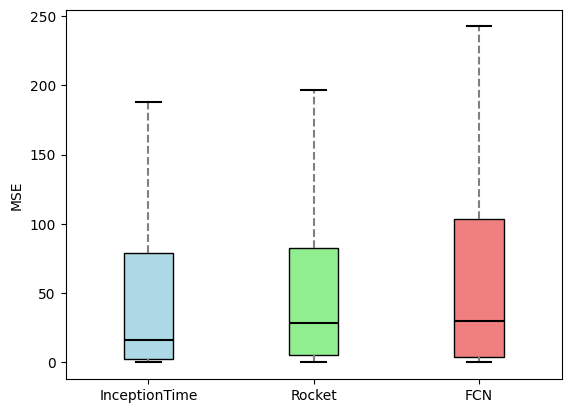

In [20]:
fig, ax = plt.subplots()
whiskerprops = dict(color='gray', linewidth=1.5, linestyle='--')
capprops = dict(color='black', linewidth=1.5)
medianprops = dict(linestyle='-', linewidth=1.5, color='black')

bplot = ax.boxplot(
    [results_data_it['MSE'][:-1], results_data_rock['MSE'][:-1], results_data_fcn['MSE'][:-1]],
    capprops=capprops,
    whiskerprops=whiskerprops,
    medianprops=medianprops,
    patch_artist=True,
    showfliers=False 
)

colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(['InceptionTime', 'Rocket', 'FCN'])
ax.set_ylabel('MSE')
plt.savefig("../results/graph.png")
plt.show()


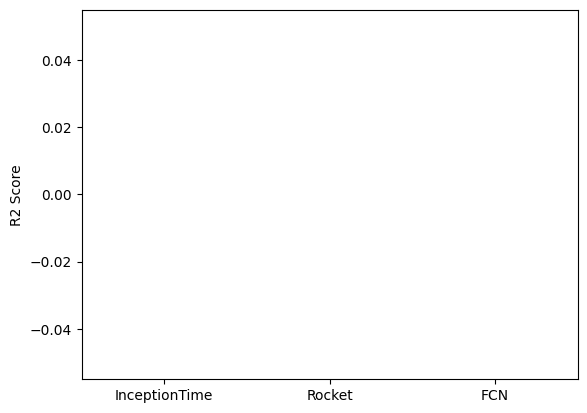

In [7]:
fig, ax = plt.subplots()
whiskerprops = dict(color='gray', linewidth=1.5, linestyle='--')
capprops = dict(color='black', linewidth=1.5)
medianprops = dict(linestyle='-', linewidth=1.5, color='black')
bplot = ax.boxplot([results_data_it['R2 Score'][:-1], results_data_rock['R2 Score'][:-1], results_data_fcn['R2 Score'][:-1]], capprops=capprops, whiskerprops=whiskerprops, medianprops=medianprops, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xticklabels(['InceptionTime', 'Rocket', 'FCN'])
ax.set_ylabel('R2 Score')
plt.show()


In [8]:
from scipy.stats import wilcoxon

test_Inception_Rocket = wilcoxon(results_data_it['MSE'][:-1].values, results_data_rock['MSE'][:-1].values)
test_Inception_FCN = wilcoxon(results_data_it['MSE'][:-1].values, results_data_fcn['MSE'][:-1].values)
test_Rocket_FCN = wilcoxon(results_data_rock['MSE'][:-1].values, results_data_fcn['MSE'][:-1].values)



In [9]:
test_Inception_Rocket

WilcoxonResult(statistic=np.float64(5310.0), pvalue=np.float64(0.6975742872017877))

In [10]:
test_Inception_FCN

WilcoxonResult(statistic=np.float64(4558.0), pvalue=np.float64(0.06753023278696206))

In [11]:
test_Rocket_FCN

WilcoxonResult(statistic=np.float64(4866.0), pvalue=np.float64(0.2155183855908318))

In [23]:
!pip install scikit-posthocs > /dev/null


Installing packages through the IPython console doesn't work reliably in Spyder. Please use a system terminal to do that, i.e. cmd.exe on Windows, Terminal on macOS or xterm on Linux.


In [12]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

data = {
    'Int_MSE': results_data_it['MSE'][:-1],
    'Rocket_MSE': results_data_rock['MSE'][:-1],
    'FCN_MSE': results_data_fcn['MSE'][:-1]
  }
df_mse = pd.DataFrame(data)

modelos_mse = [
    df_mse['Int_MSE'].values,
    df_mse['Rocket_MSE'].values,
    df_mse['FCN_MSE'].values
]

nomes_modelos = ['InceptionTime', 'Rocket', 'FCN']
alfa = 0.05 # Nível de significância

print(f"\n--- Dados de Entrada (Primeiras 5 linhas) ---\n{df_mse.head()}")

# Teste de Friedman (Omnibus)
stat, p_friedman = friedmanchisquare(*modelos_mse)

print(f"Estatística Qui-quadrado de Friedman: {stat:.4f}")
print(f"p-value de Friedman: {p_friedman:.4f}")

if p_friedman < alfa:
    print(f"\n REJEITAR H0: Há uma diferença estatisticamente significativa entre o MSE de pelo menos um par de modelos (p < {alfa}).")
    executar_posthoc = True
else:
    print(f"\n NÃO REJEITAR H0: Não há evidências de diferença significativa no MSE entre os modelos (p >= {alfa}).")
    executar_posthoc = False

if executar_posthoc:
    print("\n Executando Teste Post-Hoc de Nemenyi")

    # Reformatar os dados
    # O scikit-posthocs precisa dos dados no formato (N_observações, N_grupos)
    data_matrix = np.array(modelos_mse).T

    # Executar o Teste de Nemenyi
    ph_nemenyi = sp.posthoc_nemenyi_friedman(data_matrix)

    ph_nemenyi.columns = nomes_modelos
    ph_nemenyi.index = nomes_modelos

    print("\n Matriz de Valores p do Nemenyi (Comparações Par a Par)")
    print(ph_nemenyi.round(4))

    print("Interpretações:\n")
    for i in range(len(nomes_modelos)):
        for j in range(i + 1, len(nomes_modelos)):
            m1 = nomes_modelos[i]
            m2 = nomes_modelos[j]
            p_value = ph_nemenyi.loc[m1, m2]

            if p_value < alfa:
                print(f"  * {m1} vs {m2}: Diferença SIGNIFICATIVA (p={p_value:.4f})")
            else:
                print(f"  * {m1} vs {m2}: Nenhuma diferença SIGNIFICATIVA (p={p_value:.4f})")


--- Dados de Entrada (Primeiras 5 linhas) ---
     Int_MSE  Rocket_MSE     FCN_MSE
0  44.995714  196.348522  101.501464
1  58.319518  129.547146    5.708568
2   0.101522    8.309062   29.193492
3  33.904366    1.613219   19.896009
4  82.740915  157.073871  399.789507
Estatística Qui-quadrado de Friedman: 2.7162
p-value de Friedman: 0.2571

 NÃO REJEITAR H0: Não há evidências de diferença significativa no MSE entre os modelos (p >= 0.05).


In [18]:
# Calcular estatísticas para cada modelo
results = []

threshold = (y_mean * 0.15) ** 2

for model_name, mse_values in data.items():
    # Estatísticas básicas
    media = np.mean(mse_values)
    dp = np.std(mse_values, ddof=1)  # ddof=1 para desvio padrão amostral
    mediana = np.median(mse_values)
    minimo = np.min(mse_values)
    maximo = np.max(mse_values)
    n = len(mse_values)
    
    # Contar instâncias com MSE > threshold
    count_above_threshold = np.sum(mse_values < threshold)
    prop_above_threshold = count_above_threshold / n * 100  # em porcentagem
    
    results.append({
        'Modelo': model_name,
        'Média': media,
        'DP': dp,
        'Mediana': mediana,
        'Mínimo': minimo,
        'Máximo': maximo,
        f'Instâncias < (y_mean*0.15)²': count_above_threshold,
        f'% < (y_mean*0.15)²': prop_above_threshold,
        'N': n
    })

# Criar DataFrame
stats_df = pd.DataFrame(results)

# Formatar a exibição
pd.set_option('display.float_format', lambda x: f'{x:.6f}')

print(f"Tabela 1: Estatísticas do MSE por modelo (Threshold = {threshold:.6f})")
print("=" * 100)
print(stats_df.to_string(index=False))


Tabela 1: Estatísticas do MSE por modelo (Threshold = 6.087095)
    Modelo      Média         DP   Mediana   Mínimo      Máximo  Instâncias < (y_mean*0.15)²  % < (y_mean*0.15)²   N
   Int_MSE  84.813359 162.622422 15.949815 0.008767  932.028724                           52           35.135135 148
Rocket_MSE  72.586674 108.663502 28.190921 0.000006  573.405492                           41           27.702703 148
   FCN_MSE 115.913535 260.220452 29.808227 0.000456 2205.938695                           48           32.432432 148
